# Spectrally Normalized Generative Adversarial Networks (SN-GAN)

In [ ]:
import torch
from torch import nn

from tqdm.auto import tqdm

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

torch.manual_seed(0)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2  # normalise
    image_unflat = image_tensor.detach().cpu()  # shift the tensor to cpu
    image_grid = make_grid(image_unflat[:num_images], nrow=5)  # make grid
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  # imshow takes in H, W, C rather than C, H, W
    plt.show()

### Generator

In [ ]:
# For initialising generator, we need to know input channels(dim of z),
# output channels(channels in image), and hidden channels parameters
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector,
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Discriminator

In [ ]:
# For initialising discriminator, we need to know
# input channels(channels in img), and the hidden
# channels
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


### Training SN-DCGAN

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 170973850.57it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 87715926.01it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70080472.18it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3537702.65it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# initializing the generator, the discriminator, and the optimizers.
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# I initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.6945082342624667, discriminator loss: 0.6961673011779782


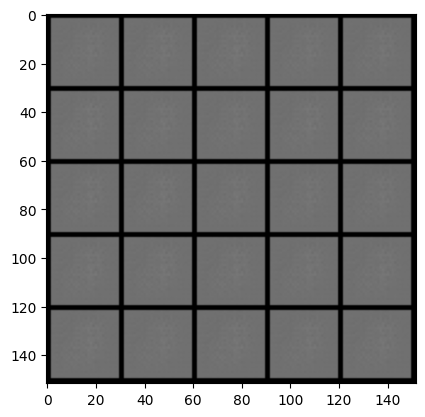

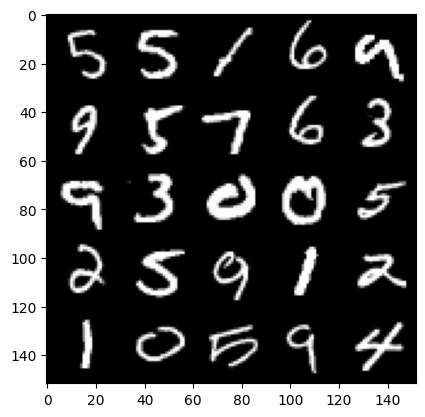

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6932518510818483, discriminator loss: 0.6932018580436704


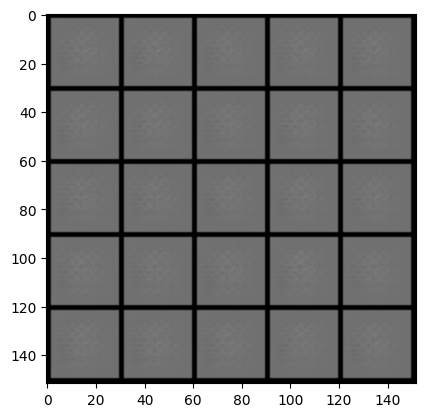

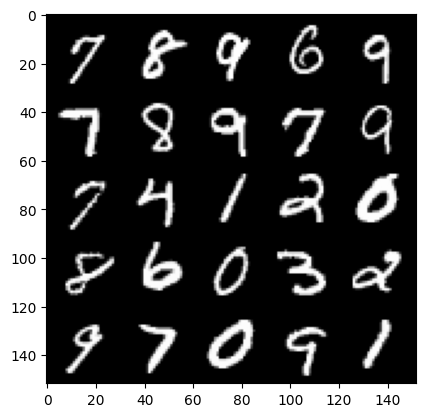

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.6932767727375028, discriminator loss: 0.6931650048494329


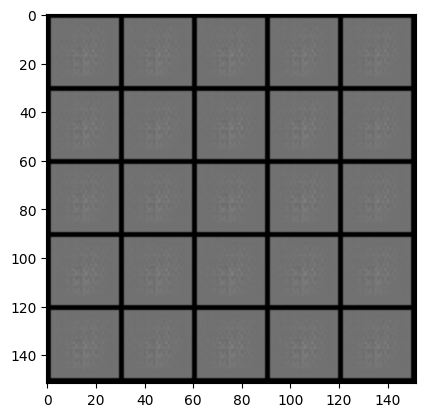

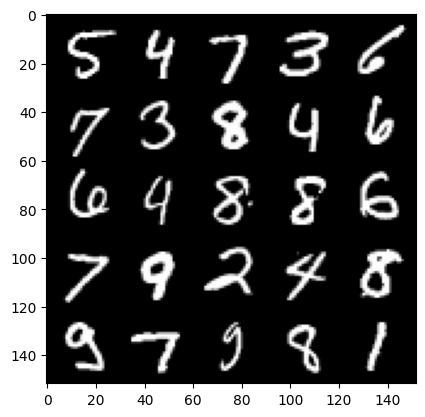

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6934469797611238, discriminator loss: 0.6932339452505106


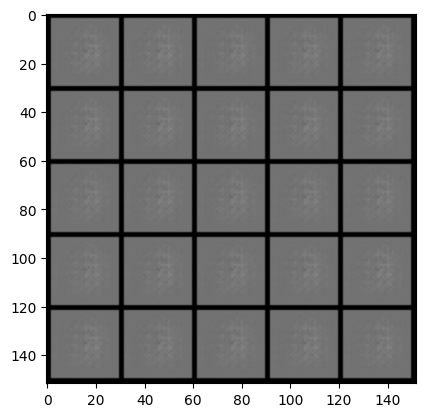

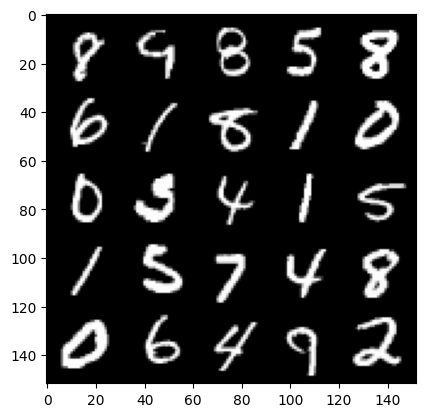

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.693297555446625, discriminator loss: 0.6931891427040106


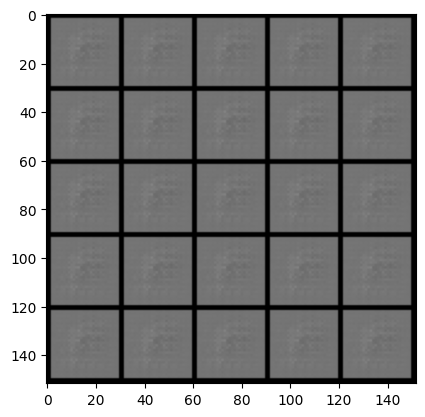

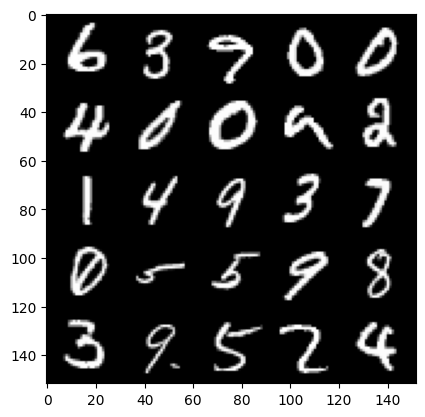

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6932013899087907, discriminator loss: 0.6931725858449936


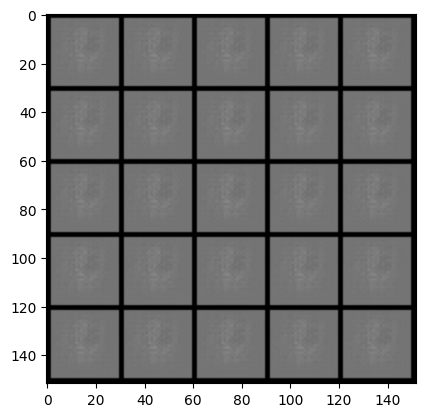

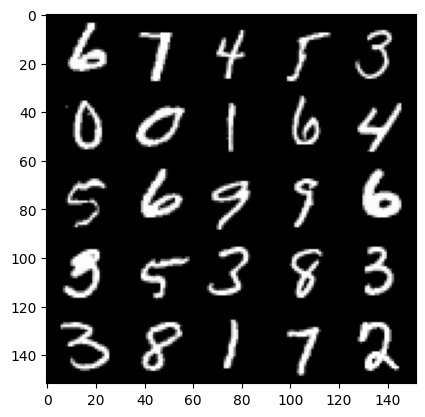

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.6935349689722068, discriminator loss: 0.6932587299346925


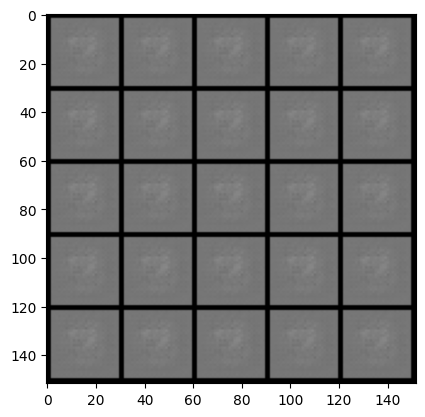

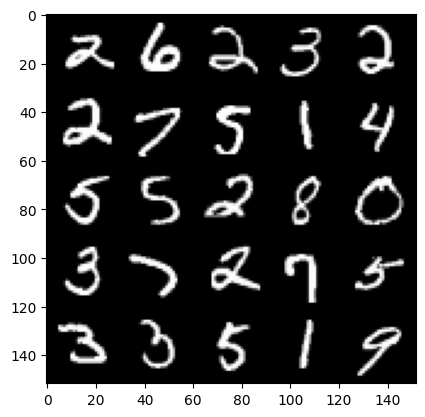

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6932125935554505, discriminator loss: 0.6931558629274363


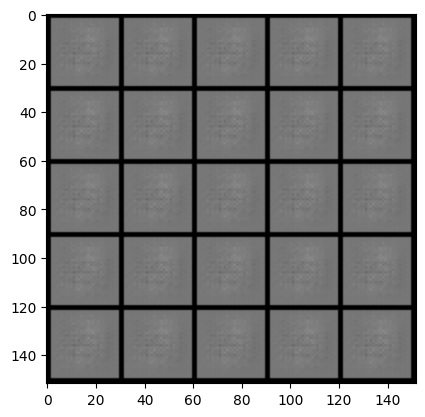

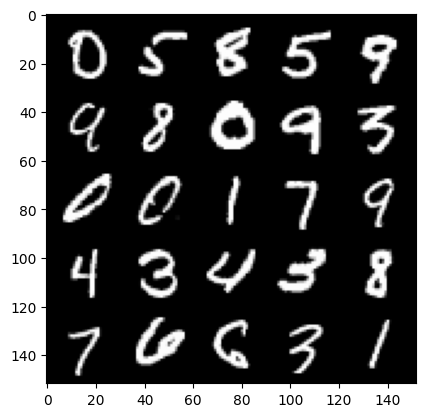

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6932138917446139, discriminator loss: 0.6931665829420086


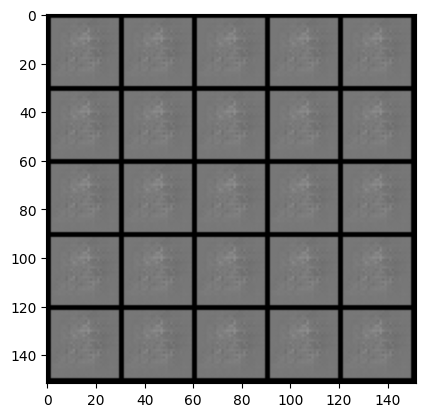

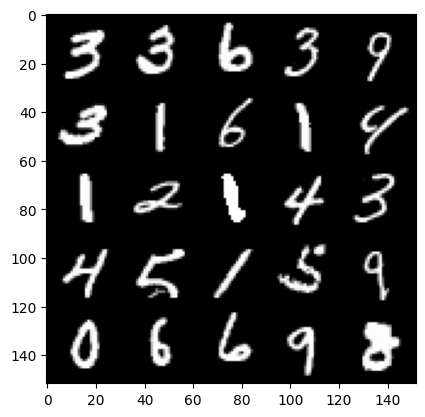

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.693192182779312, discriminator loss: 0.693160951018333


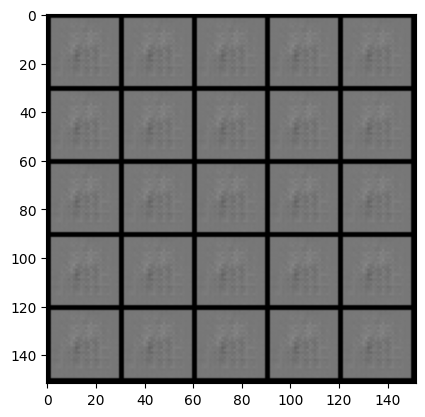

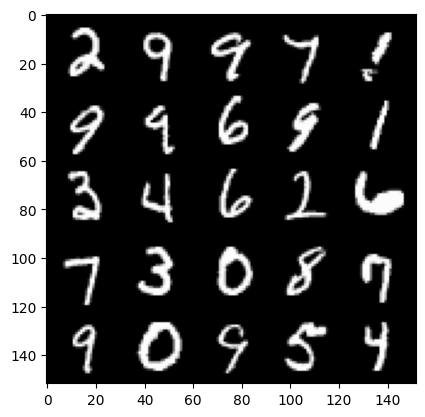

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.6934094159603117, discriminator loss: 0.6931868392229076


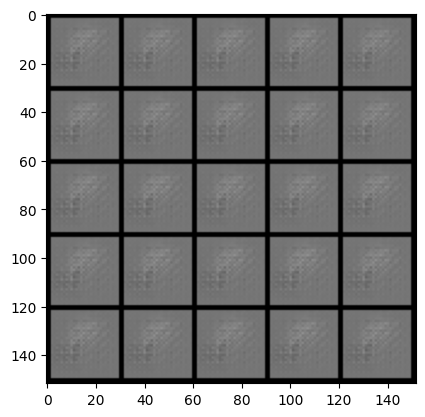

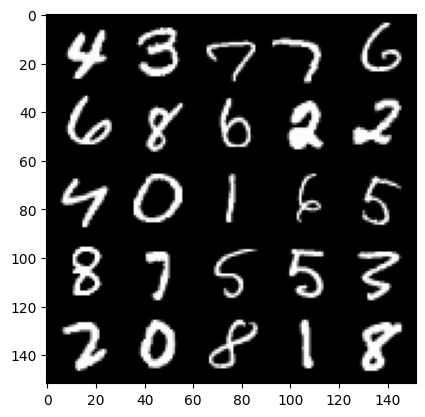

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.693312442779541, discriminator loss: 0.6931771479845047


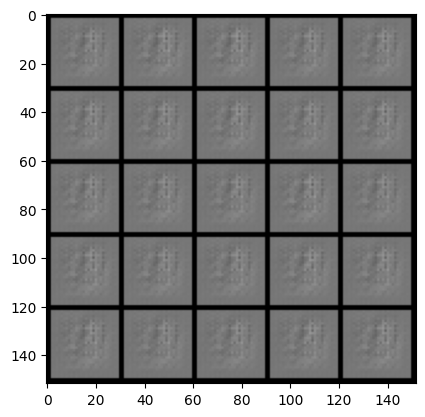

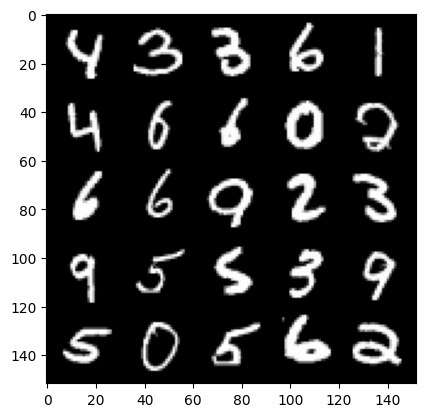

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.6934363632202148, discriminator loss: 0.6931851952075957


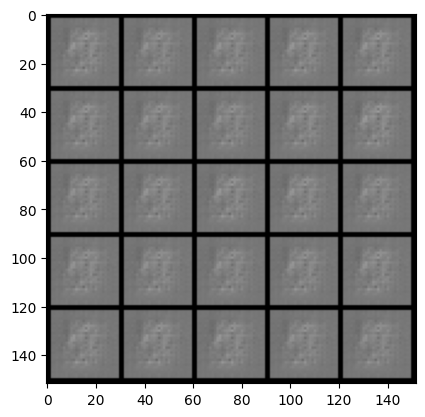

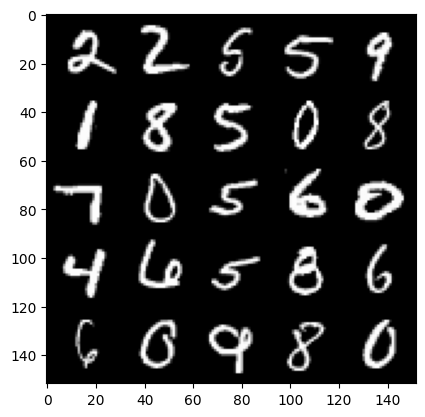

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6952070559263223, discriminator loss: 0.6919057859182356


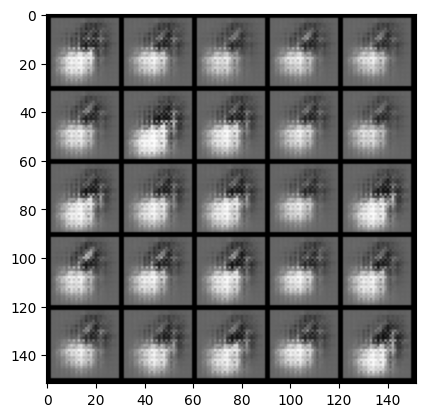

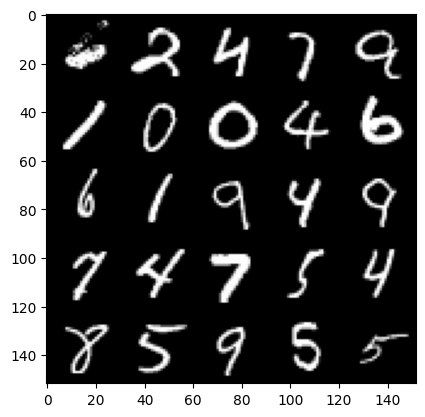

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7397274065017703, discriminator loss: 0.6750227360725394


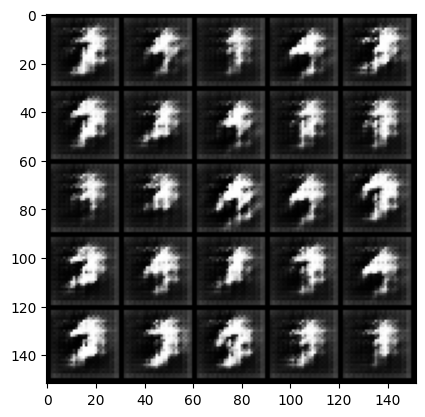

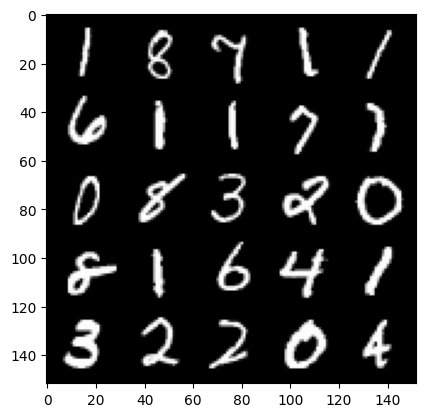

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7316133936643604, discriminator loss: 0.6744436160326001


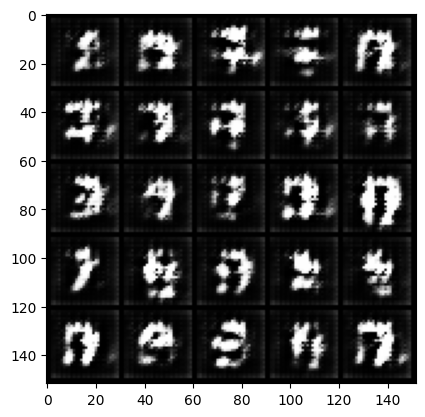

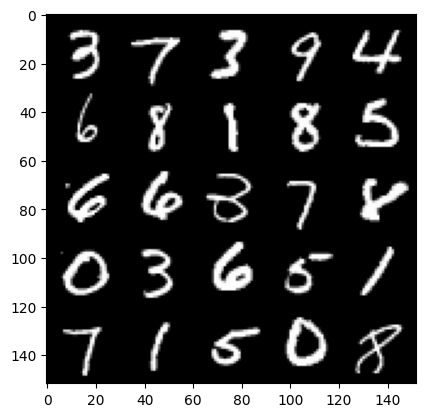

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7187638636827469, discriminator loss: 0.6837045495510097


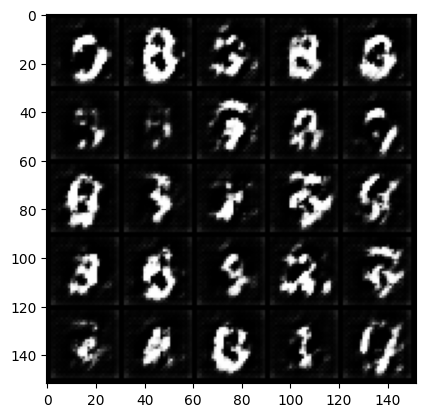

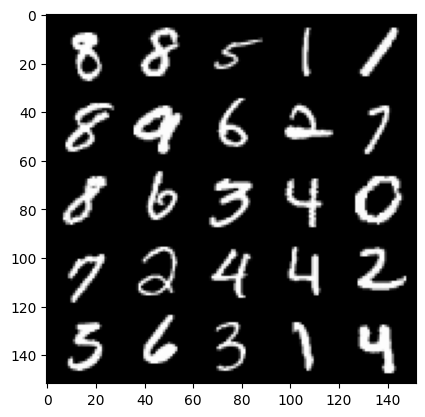

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7176986703872682, discriminator loss: 0.6824157015085216


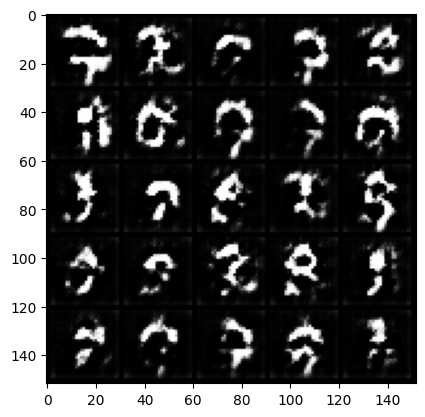

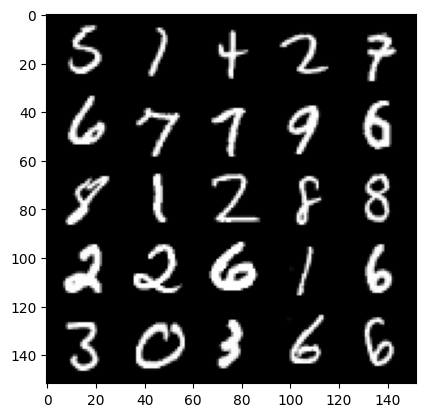

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7103834049701697, discriminator loss: 0.6835087814331047


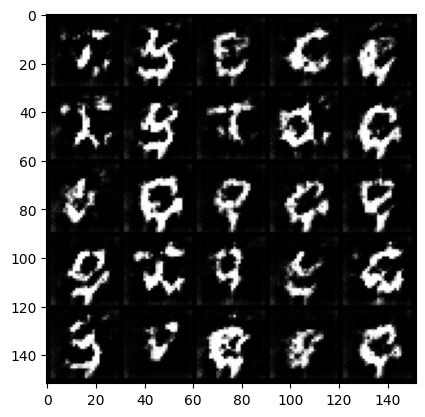

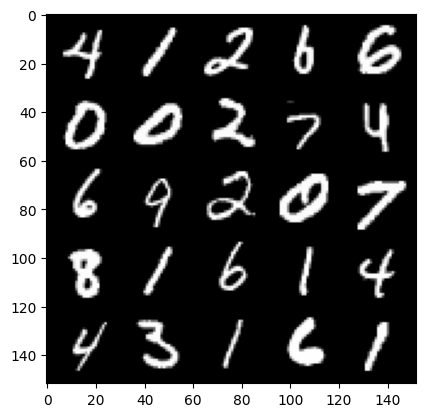

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7049714481830597, discriminator loss: 0.6875898512601849


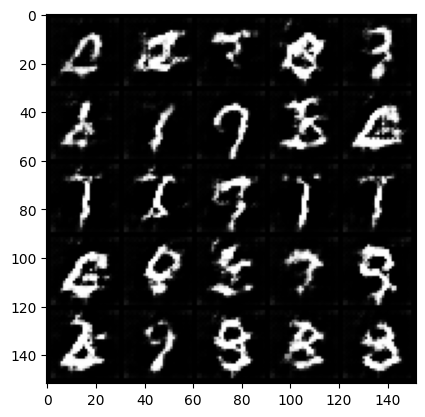

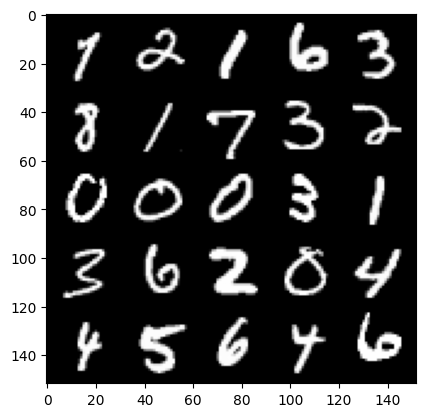

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7005364818572999, discriminator loss: 0.6925126683712002


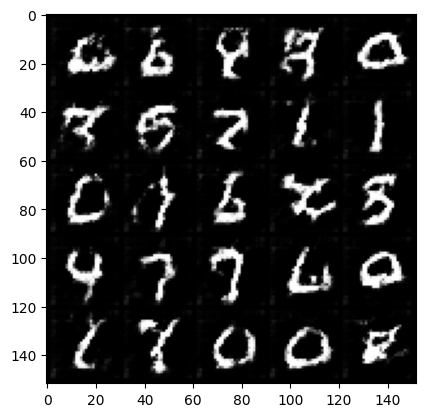

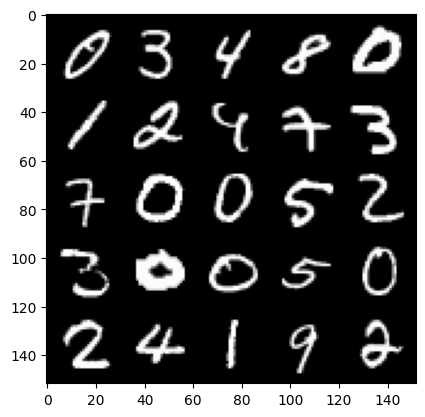

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6981697435379027, discriminator loss: 0.6934458622932436


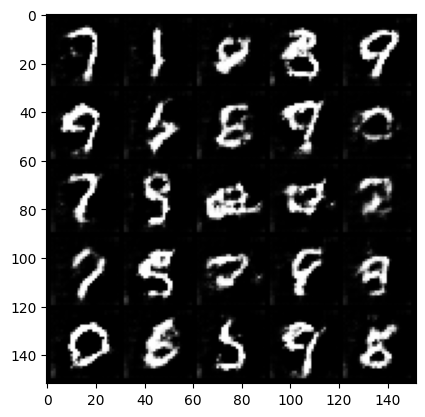

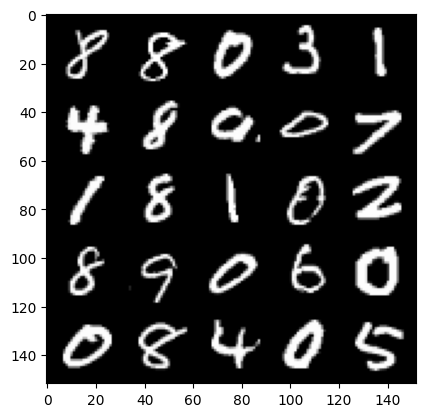

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.6986246089935293, discriminator loss: 0.6928648335933683


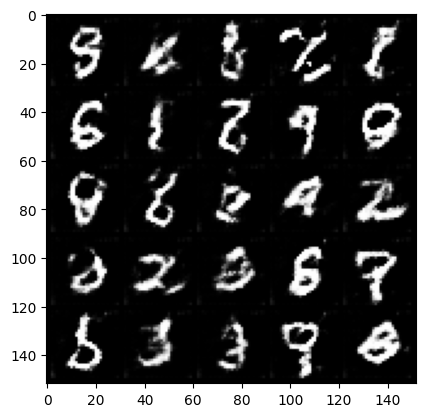

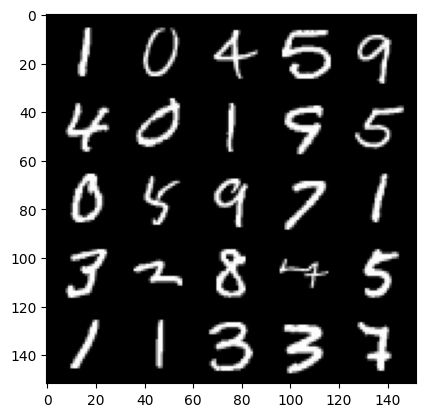

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6977931255102153, discriminator loss: 0.6928115854263303


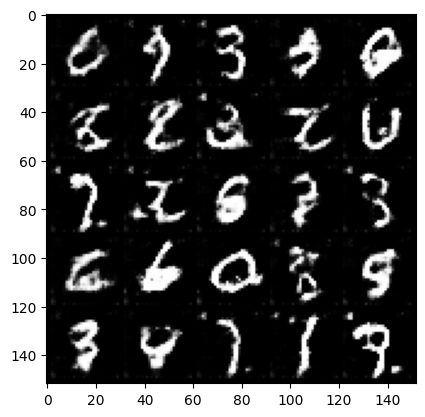

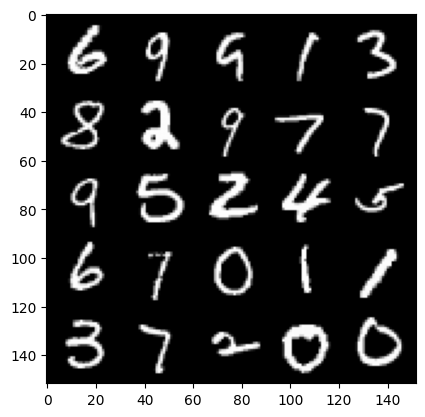

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.6962340352535258, discriminator loss: 0.6932537949085232


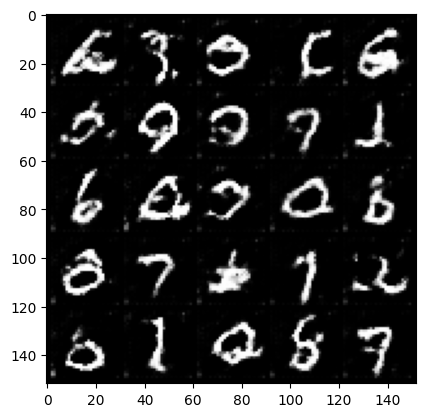

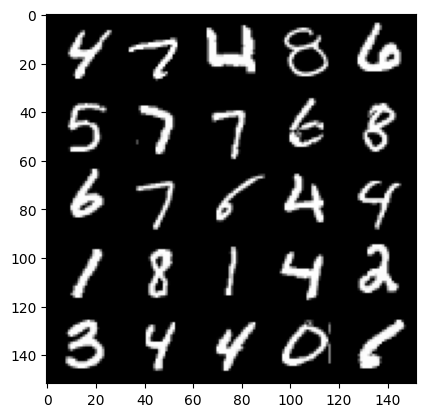

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6961139535903941, discriminator loss: 0.6932265847921378


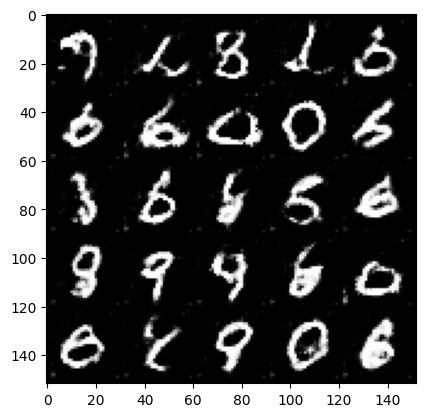

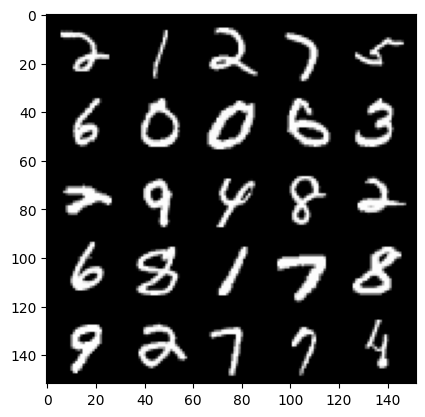

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.6952151370048522, discriminator loss: 0.6936097673177718


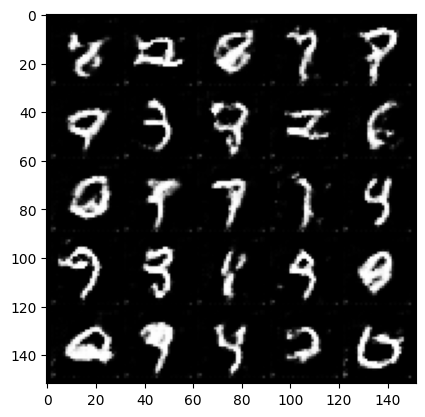

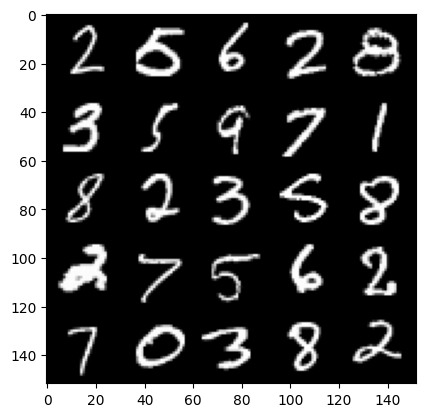

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.6949309227466588, discriminator loss: 0.6936052918434155


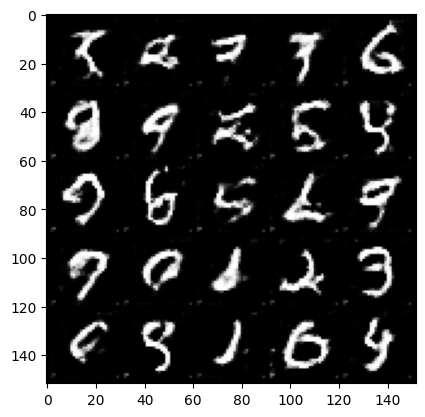

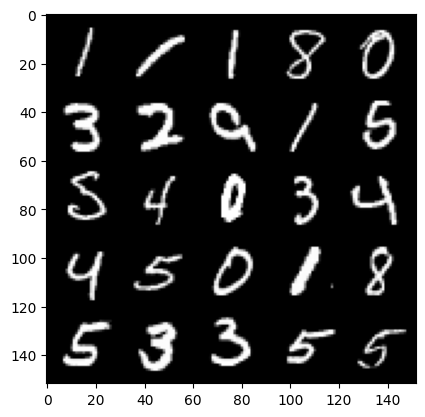

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.6949833509922027, discriminator loss: 0.6936106353998184


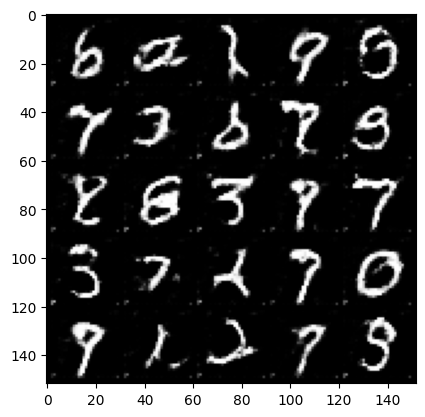

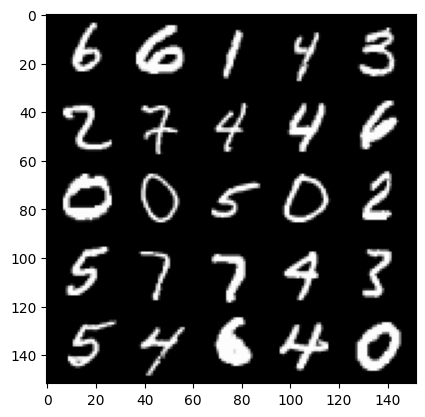

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6938243571519853, discriminator loss: 0.6936257010698312


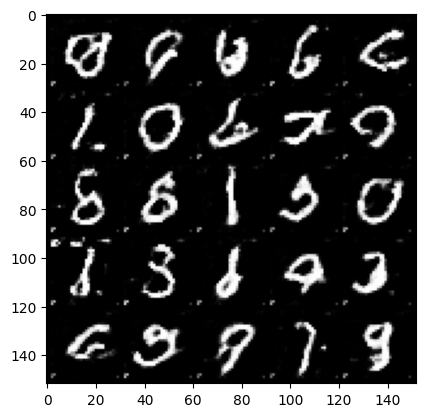

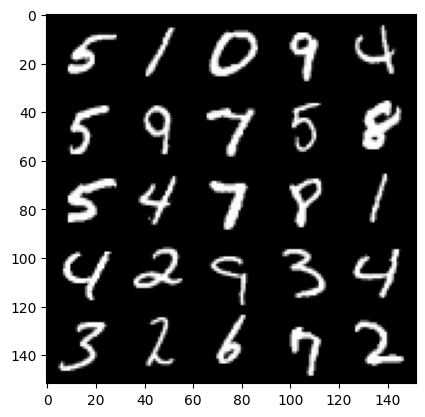

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.694637642025947, discriminator loss: 0.693690140485763


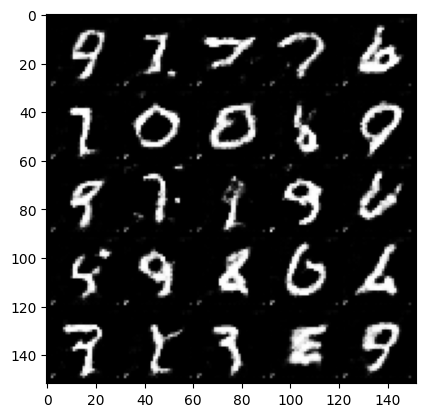

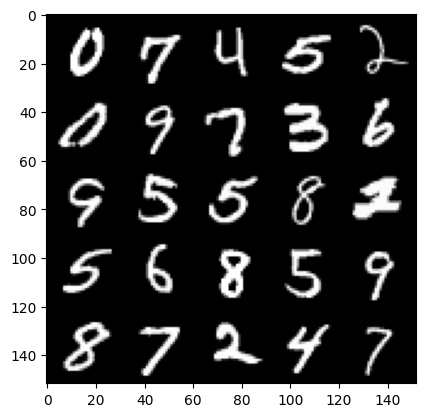

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6942835733890537, discriminator loss: 0.6938586719036106


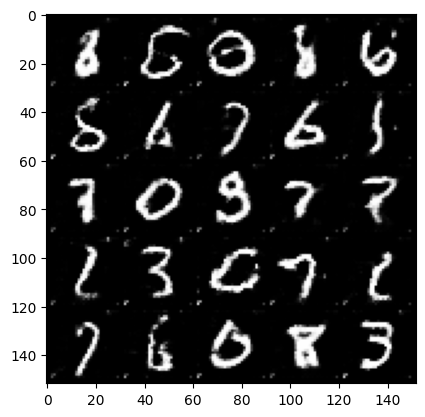

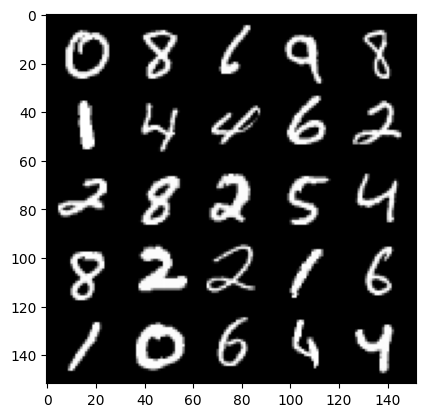

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.6960463575124749, discriminator loss: 0.6941569744348525


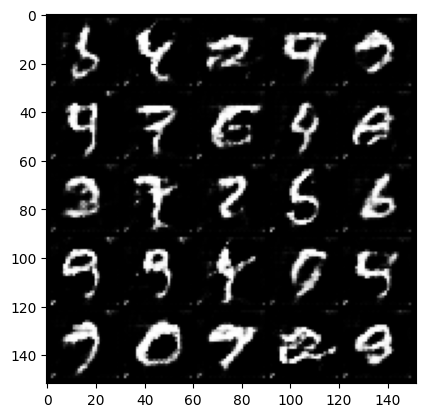

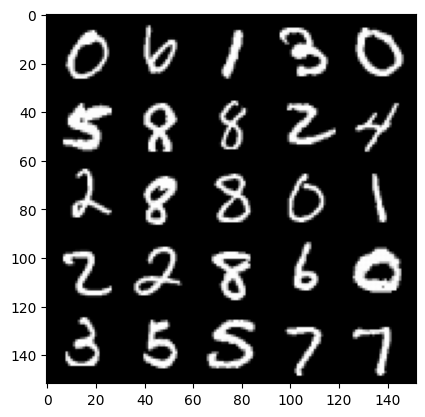

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6948552491664884, discriminator loss: 0.6938098071813587


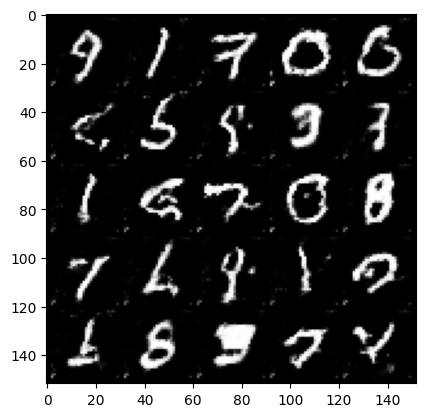

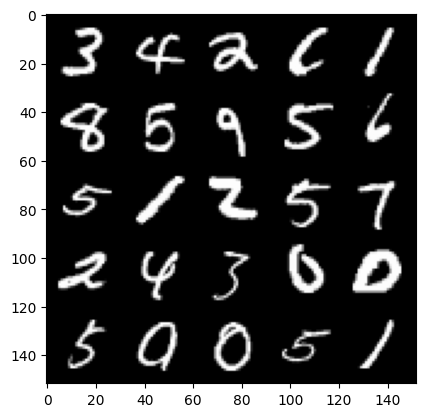

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.6940182118415832, discriminator loss: 0.693959547638893


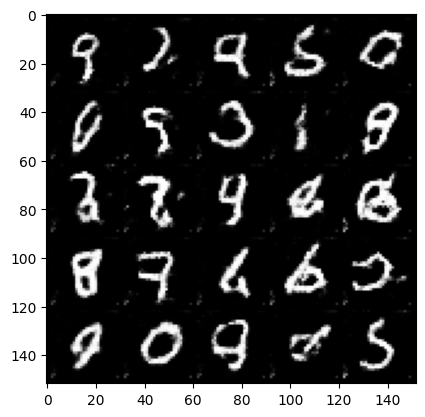

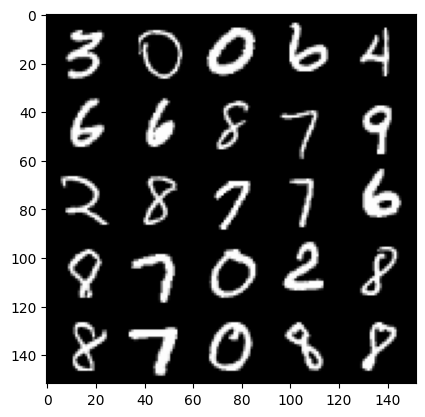

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1